# Cooling coffee

In [ ]:
# download modsim.py if necessary

from os.path import exists

filename = 'modsim.py'
if not exists(filename):
    from urllib.request import urlretrieve
    # url = 'https://raw.githubusercontent.com/AllenDowney/ModSim/main/'
    url = "https://raw.githubusercontent.com/AllenDowney/ModSimPy/master/"
    local, _ = urlretrieve(url+filename, filename)
    print('Downloaded ' + local)

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

In [3]:
def make_system(T_init, volume, r, t_end, T_env=22, t_0=0, dt=1):
    return modsim.System(
        T_init=T_init,
        T_final=T_init,
        volume=volume,
        r=r,
        t_end=t_end,
        T_env=T_env,
        t_0=t_0,
        dt=dt,
)

In [5]:
coffee = make_system(T_init=90, volume=300, r=0.01, t_end=30)
print(coffee)

System(T_init=90, T_final=90, volume=300, r=0.01, t_end=30, T_env=22, t_0=0, dt=1)


In [6]:
def change_func(t, T, system):
    r, T_env, dt = system.r, system.T_env, system.dt    
    return -r * (T - T_env) * dt

In [7]:
change_func(0, coffee.T_init, coffee)

-0.68

In [8]:
def run_simulation(system, change_func):
    t_array = modsim.linrange(system.t_0, system.t_end, system.dt)
    n = len(t_array)
    
    series = modsim.TimeSeries(index=t_array)
    series.iloc[0] = system.T_init
    
    for i in range(n - 1):
        t = t_array[i]
        T = series.iloc[i]
        series.iloc[i+1] = T + change_func(t, T, system)
    
    system.T_final = series.iloc[-1]
    return series

In [10]:
import inspect

In [13]:
print(inspect.getsource(modsim.linrange))

def linrange(start, stop=None, step=1, **options):
    """Make an array of equally spaced values.

    start: first value
    stop: last value (might be approximate)
    step: difference between elements (should be consistent)

    returns: NumPy array
    """
    if stop is None:
        stop = start
        start = 0
    n = int(round((stop-start) / step))
    return linspace(start, stop, n+1, **options)



In [16]:
print(inspect.getsource(modsim.show))

def show(obj):
    """Display a Series or Namespace as a DataFrame."""
    if isinstance(obj, pd.Series):
        df = pd.DataFrame(obj)
        return df
    elif hasattr(obj, '__dict__'):
        return pd.DataFrame(pd.Series(obj.__dict__),
                            columns=['value'])
    else:
        return obj



In [15]:
results = run_simulation(coffee, change_func)
modsim.show(results.head())

,Quantity
Time,
0.0,90.000000
1.0,89.320000
2.0,88.646800
3.0,87.980332
4.0,87.320529


In [17]:
modsim.show(results.tail())

,Quantity
Time,
26.0,74.362934
27.0,73.839305
28.0,73.320912
29.0,72.807702
30.0,72.299625


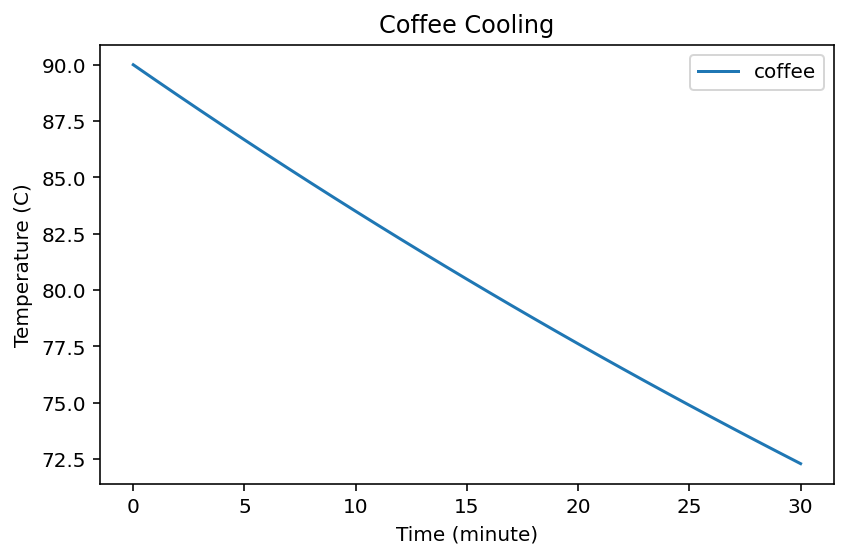

In [18]:
results.plot(label='coffee')

modsim.decorate(xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Coffee Cooling')

In [19]:
coffee.T_final

72.2996253904031

In [20]:
def func(x):
    return (x-1) * (x-2) * (x-3)

In [21]:
res = modsim.root_scalar(func, bracket=[1.5, 2.5])
res

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 2.0

In [22]:
res = modsim.root_scalar(func, bracket=[2.5, 3.5])
res.root

2.9999771663211003

In [23]:
def error_func(r, system):
    system.r = r
    results = run_simulation(system, change_func)
    return system.T_final - 70

In [24]:
coffee = make_system(T_init=90, volume=300, r=0.01, t_end=30)
error_func(0.01, coffee)

2.2996253904030937

In [25]:
error_func(0.02, coffee)

-10.907066281994297

In [26]:
res = modsim.root_scalar(error_func, coffee, bracket=[0.01, 0.02])
res

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 0.011543084190599507

In [27]:
r_coffee = res.root
r_coffee

0.011543084190599507

In [28]:
coffee.r = res.root
run_simulation(coffee, change_func)
coffee.T_final

70.00000057308064

### Exercise 1
Simulate the temperature of 50 mL of milk with a starting temperature of 5 °C, in a vessel with `r=0.1`, for 15 minutes, and plot the results. Use `make_system` to make a `System` object that represents the milk, and use `run_simulation` to simulate it. By trial and error, find a value for `r` that makes the final temperature close to 20 °C.

In [29]:
milk = make_system(T_init=5, volume=50, r=0.1, t_end=15)
print(milk)

System(T_init=5, T_final=5, volume=50, r=0.1, t_end=15, T_env=22, t_0=0, dt=1)


In [30]:
results_milk = run_simulation(milk, change_func)

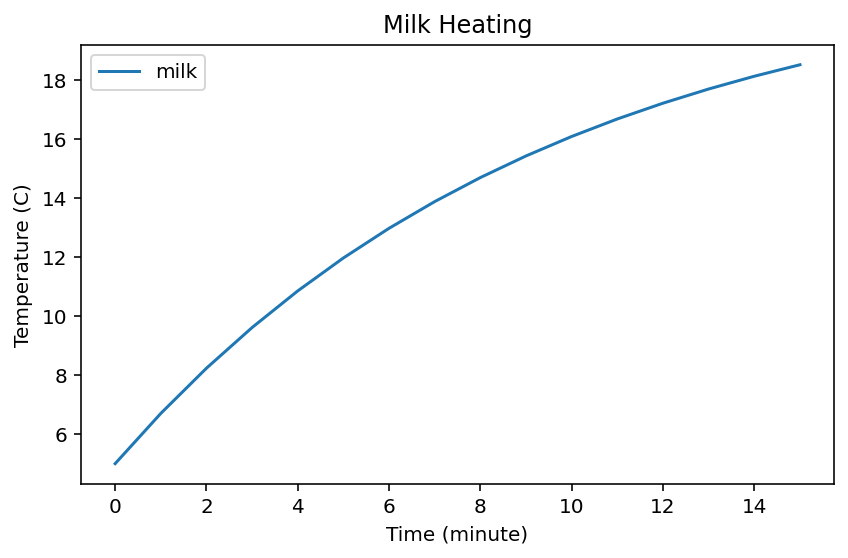

In [31]:
results_milk.plot(label='milk')

modsim.decorate(xlabel='Time (minute)',
         ylabel='Temperature (C)',
         title='Milk Heating')

In [32]:
def error_func_general(r, system, T_final):
    system.r = r
    results = run_simulation(system, change_func)
    return system.T_final - T_final

In [35]:
error_func_general(0.05, milk, 20), error_func_general(0.15, milk, 20)

(-5.875950912715808, 0.5149782752787182)

In [42]:
r_array = numpy.linspace(0.02, 0.2, 19)
r_array

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [54]:
def trial_error_r(r_array):
    for r in r_array:
        print(f"{r:0.5f} \t {error_func_general(r, milk, 20):.5f}")


In [55]:
trial_error_r(r_array)

0.13000 	 -0.10493
0.13050 	 -0.08686
0.13100 	 -0.06893
0.13150 	 -0.05114
0.13200 	 -0.03350
0.13250 	 -0.01600
0.13300 	 0.00136
0.13350 	 0.01858
0.13400 	 0.03566
0.13450 	 0.05260
0.13500 	 0.06941


In [59]:
r_array = numpy.linspace(0.1329, 0.133, 11)
trial_error_r(r_array)

0.13290 	 -0.00210
0.13291 	 -0.00176
0.13292 	 -0.00141
0.13293 	 -0.00107
0.13294 	 -0.00072
0.13295 	 -0.00037
0.13296 	 -0.00003
0.13297 	 0.00032
0.13298 	 0.00066
0.13299 	 0.00101
0.13300 	 0.00136


### Exercise 2
Write an error function that simulates the temperature of the milk and returns the difference between the final temperature and 20 °C. Use it to estimate the value of `r` for the milk.



In [63]:
def error_func_20(r, system):
    system.r = r
    results = run_simulation(system, change_func)
    return system.T_final - 20

In [79]:
roots_r_milk = modsim.root_scalar(error_func_20, milk, bracket=[0.1, 0.15])

In [69]:
roots_r_milk

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.13296080084222728